# 프로젝트 : 멋진 단어사전 만들기
**페이지가 춤을 출 경우 페이지 확대나 축소해서 봐주세요.**

## 1. 데이터 준비하기
- **데이터 불러오기**
- **데이터 전처리**
- **SentencePiece모델 만들기**

## 2. 여러 모델 비교하기
- **SentencePiece(unigram)**
- **KoNLPy**
- **SentencePiece(bpe)**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


- - -
### 데이터 준비하기
- **데이터 불러오기**

In [ ]:
# !mkdir -p ~/aiffel/GoingDeeper/dataset/sentiment_classification

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/GoingDeeper/dataset/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/GoingDeeper/dataset/sentiment_classification/ratings_test.txt')

print(train_data.shape)
print(test_data.shape)

train_data.head()

(150000, 3)
(50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


[네이버 영화 리뷰 감성 분석 태스크](https://github.com/e9t/nsmc/) 데이터셋입니다.

In [ ]:
train_data.drop_duplicates(['document'], inplace=True)
train_data.dropna(how='any', inplace=True)

test_data.drop_duplicates(['document'], inplace=True)
test_data.dropna(how='any', inplace=True)

data = pd.concat([train_data, test_data], axis=0)

data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


간단하게 중복과 결측치를 제거해줍니다.

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/tmp/ipykernel_31/1440982664.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


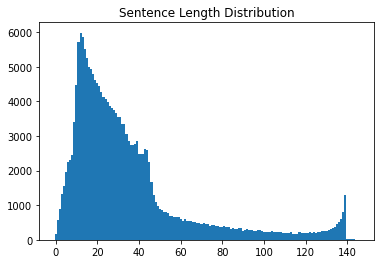

In [ ]:
def show_sentence_length(raw):
    len_sen = [len(sen) for sen in raw]

    print("문장의 최단 길이:", min(len_sen))
    print("문장의 최장 길이:", max(len_sen))
    print("문장의 평균 길이:", sum(len_sen) // len(raw))

    max_len = max(len_sen)
    sentence_length = np.zeros((max_len), dtype=np.int)

    for i in range(max_len):
        sentence_length[i] = len_sen.count(i+1)

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()
    
    return sentence_length

sentence_length = show_sentence_length(data['document'])

문장의 길이 분포를 살펴보면 마냥 이쁜 모양은 아니네요.

In [ ]:
for idx, _sum in enumerate(sentence_length):
    if _sum > 500 and idx > 135:
        print("Outlier Index:", idx+1)

Outlier Index: 137
Outlier Index: 138
Outlier Index: 139
Outlier Index: 140


분포의 마지막에 가장 우뚝 솟아있는 건 길이가 140인 문장들이겠네요.

어떻게 절묘하게 길이가 140인 문장이 많은걸까요?

In [ ]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 50: return

check_sentence_with_length(data['document'], 140)

데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다닐지라도,소설 속에선 제일 멋진 놈이 자이메 라니스터였는데,드라마속에선,드래곤(용)이 제일 멋지네(웃음)감독님 토르-2 다크 월드는 말아 잡수셨을지라도,기본 선방은 했음
아~ 진짜 조금만 더 손 좀 보면 왠만한 상업 영화 못지 않게 퀄리티 쩔게 만들어 질 수 있었는데 아쉽네요 그래도 충분히 재미있었습니다 개인적으로 조금만 더 잔인하게 더 자극적으로 노출씬도 화끈하게 했더라면 어땠을까 하는 국산영화라 많이 아낀 듯 보임
평점조절위원회에서 나왔습니다(웃음)김혜선은 @내일이 오면@의 김순정,순정이 역할이 제일이다.팜므파탈로써,그 정도까지 잘해낼 줄은,정말 의외였어...연기20년 한사람에게 요즘 사극에서 벌어지고 있는,그녀에 대한 연기논란은 왠지 코미디의한장면 같음(웃음)
사실여부를 떠나,알고왔던 아더와 너무 매칭이 안돼더라.원탁기사중 실제 검술 최고수는 랜슬롯으로 알고 있는데,트리스탄보다 못하고,싸우는 검술은 마치 중국검술 흉내낸거 같은게;; 그리고 란슬롯이 실제는 쌍검였나?너무 매칭이 안대 하튼 ㅋ기네비어역도 미스.
진짜 이건 아님ㅋㅋㅋㅋㅋ액션영화좋아해서 액션영화만 다운받아서 꾸준히 본게 벌써 몇년인 사람임 근데 이건 진짴ㅋㅋㅋㅋㅋㅋ아무리 점수 잘 줘도 100점 만점에 10점?ㅡㅡ돈주고봤는데너무아깝다진짜ㅜㅜ그리고대체 왜 13구역 타이틀을 달고나왔는지 모르겠음 실망
영화'산업'이라고 하잖는가? 이딴식으로 홍보 해놓고 속여서 팔았다는 게 소비자 입장에서는 짜증난다. 그나마 다행은 아주 싸구려를 상급품으로 속여판 게 아니라는 점. 그래서 1점. 차라리 연상호 감독 작품 처럼 홍보가 됐다면, 그 비슷하게 만이라도 하지
화려한 색채때문에 눈이 아프지만 그 나름대로 화려연예계여자욕망에대해 표현해냈던거같다 보는내내 진짜 리리코심정가진 연옌들도 있을거같고..나를한번도보지못하고알지못하는사람들이날어떻게사랑하냐그런대사 나왔을때 소름돋더라 연예인들은 많은사랑받으면서도 참 허전할듯
히가시노 게이고의 추리소

..그냥 우연의 일치라고 보겠습니다.

데이터를 확인하는 입장인 저로썬 확인하기가 힘들군요.

In [ ]:
data.loc[data['id'] == 8355974]

,id,document,label
34069,8355974,"와.,.,.,..진짜 최악이다.,.,.,.,.와,.,.,.,. 이영화랑 클레멘타인의...",0


데이터를 이리저리 둘러보다 우연히 찾은 요주의 문장입니다.

어떻게 말줄임표를 `,`과 `.`을 번갈아서 쓸 생각을 했는지..

아무튼 이 문장을 중점적으로 전처리를 진행하겠습니다.

- - -
### 데이터 준비하기
- **데이터 전처리**

In [ ]:
import re

def preprocess_sentence(sentence):
    sentence = re.sub(r"[^a-zA-Z0-9\uAC00-\uD7A3\s~!?,.']+", '', sentence) # a-z : 모든 알파벳 소문자
                                                                            # A-Z : 모든 알파벳 대문자
                                                                            # 0-9 : 모든 숫자
                                                                            # \uAC00-\uD7A3 : 모든 한글
                                                                            # \s : 공백
                                                                            # ~!?,.' : 예외시킨 특수문자들
    sentence = re.sub(r'[" "]+', " ", sentence) # 공백 중복은 하나의 공백으로
    sentence = re.sub(r'["!"]+', "!", sentence) # 느낌표 중복은 하나의 느낌표로
    sentence = re.sub(r'["?"]+', "?", sentence) # 물음표 중복은 하나의 물음표로
    sentence = re.sub(r'["~"]+', "~", sentence) # 물결표 중복은 하나의 물결표로
    sentence = re.sub(r'[",."]{2}', "..", sentence) # ,,이나 ,이 섞인 말줄임표는 ..으로
    sentence = re.sub(r'["."]{2,}', "..", sentence) # .이 두 개 이상 반복되는 말줄임표는 ..으로
    sentence = re.sub(r'["O"]{2,}', "", sentence) # OO로 필터링(추정)된 것은 제거
    sentence = sentence.strip()
    
    return sentence

train_data['document'] = train_data['document'].apply(preprocess_sentence)
test_data['document'] = test_data['document'].apply(preprocess_sentence)

data = pd.concat([train_data, test_data], axis=0)

data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


`!!, ??, ~~`와 같은 하나여도 상관 없는 감탄사는 하나만 사용하도록 줄여줬고,

`,`을 이용한 말줄임표는 모두 `.`으로 통일해주면서 `,`이 하나만 있을 경우엔 처리되지 않게 해줬습니다.

그리고 말줄임표도 `.`이 2개든 10개든 의미에는 큰 차이가 없으므로 `.`을 두 개 쓰는 것으로 통일해줬구요.

마지막으로 `OOOO` 이런 단어가 있었는데, 혹시 데이터셋을 만든 사람이 필터링을 했거나 네이버에서 자동적으로 필터링 되게끔 한 단어가 아닐까 싶었고, 

만약 그렇다면 의미가 없는 단어이니 제거해줬습니다.

문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 34


/tmp/ipykernel_31/1440982664.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


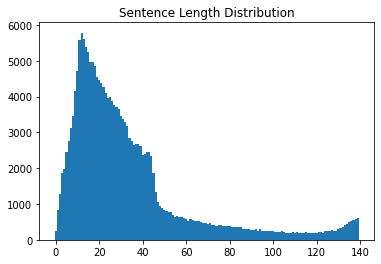

In [ ]:
sentence_length = show_sentence_length(data['document'])

전처리 결과 최단 길이가 1 → 0, 최장 길이가 146 → 140, 평균 길이가 35 → 34로

분포의 모양 또한 큰 차이가 없을 정도로 문장 자체는 크게 건드리지 않았습니다.

In [ ]:
data.loc[data['id'] == 8355974]

,id,document,label
34069,8355974,와..진짜 최악이다..와.. 이영화랑 클레멘타인의 차이점은..이영화는 돈을 좀더 썼...,0


제가 찾았던 요주의 데이터를 보니 깔끔하게 처리가 됐습니다.(뿌듯)

In [ ]:
min_len = 1
max_len = 55

data.loc[data['document'].apply(lambda x: not (min_len <= len(x) <= max_len))]

,id,document,label
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
14,9864035,취향은 존중한다지만 진짜 내생에 극장에서 본 영화중 가장 노잼 노감동임 스토리도 어...,0
16,9143163,참 사람들 웃긴게 바스코가 이기면 락스코라고 까고바비가 이기면 아이돌이라고 깐다.그...,1
22,9705777,재미없다 지루하고. 같은 음식 영화인데도 바베트의 만찬하고 넘 차이남..바베트의 만...,0
...,...,...,...
49954,8787645,5편의 존 무어 감독은 만약에 6편을 만든다 하면 4편까진 복습하고 오시길!그게 뭡...,1
49970,6833821,당신의 꿈은 지금 안녕하신가요.. 유쾌하고 감동적이고 꿈을 잊고 사는 현대인들이 보...,1
49973,8527261,영화 초반 존쿠삭이 바네사 허진스 가두고 LP로 틀던 팝송 정말 좋던데 아시는분 제...,0
49974,6694209,그래서 하고 싶은 말이 뭔데..? . 연출만 잘했더라면 훨씬 더 흥미로웠을텐데. 몇...,0


문장의 최소 길이를 1, 최대 길이를 55로 설정할 경우 제거될 데이터 목록입니다.

확인 결과 별 영향 없을 것으로 보입니다.

In [ ]:
train_data = train_data.loc[train_data['document'].apply(lambda x: min_len <= len(x) <= max_len)]
test_data = test_data.loc[test_data['document'].apply(lambda x: min_len <= len(x) <= max_len)]

data = pd.concat([train_data, test_data], axis=0)

data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


필터링 후 데이터입니다.

train과 test를 합쳐 총 *165452*개가 남았습니다.

문장의 최단 길이: 1
문장의 최장 길이: 55
문장의 평균 길이: 24


/tmp/ipykernel_31/1440982664.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


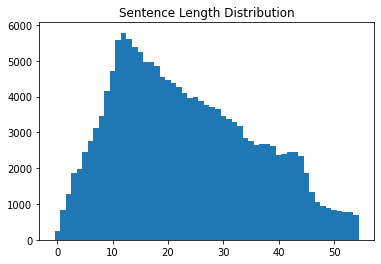

In [ ]:
sentence_length = show_sentence_length(data['document'])

분포도 확인해봅시다.

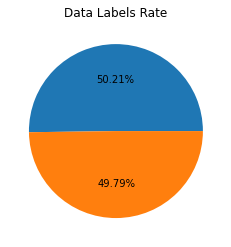

In [ ]:
plt.pie(data['label'].value_counts(), autopct='%.2f%%')
plt.title('Data Labels Rate')
plt.show()

지금까지의 전처리를 거치면서 혹시 특정 레이블 위주로 제거되진 않았는지 레이블의 비율을 확인해봤습니다.

다행히 정상입니다.

- - -
### SentencePiece 모델 만들기
- **모델 학습하기**

전처리를 마친 데이터를 가지고 SentencePiece를 학습시키겠습니다.

In [ ]:
import sentencepiece as spm
temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 10000

with open(temp_file, 'w') as f:
    for row in data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=10000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_

-rw-r--r-- 1 root root 416069 Nov 22 00:45 korean_spm.model
-rw-r--r-- 1 root root 187303 Nov 22 00:45 korean_spm.vocab


`vocab_size`는 10000으로, 옵션은 기본값인 `unigram`으로 진행하겠습니다.

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1814, 10, 436, 16, 1561, 10, 170, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


학습된 SentencePiece를 사용하면 위처럼 형태소가 분리가 되는군요.

예상보다 쓸만할 것 같습니다.

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

데이터를 받으면 텐서와 단어 사전으로 출력해주는 함수입니다.

In [ ]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 431 2878   15 1155 2346    4    0    0    0    0    0]
 [1358 1967    3    0  593   10  318 9920  736    5    4]]


리스트 형태로 넣어보면서 함수를 테스트해보면 텐서 형태로 출력되는 것까지 잘 작동됩니다.

- - -
### 여러 모델 비교하기
- **SentencePiece(unigram)**

In [ ]:
sp_data, word_index, index_word = sp_tokenize(s, data['document'])

sp_data

array([[  45,  959,    5, ...,    0,    0,    0],
       [1346,    5, 4407, ...,    0,    0,    0],
       [  22,  412, 9769, ...,    0,    0,    0],
       ...,
       [1865,   11,  531, ...,    0,    0,    0],
       [ 521, 1173,   12, ...,    0,    0,    0],
       [2273,   12,  175, ...,    0,    0,    0]], dtype=int32)

첫 번째로 SentencePiece를 unigram으로 학습한 모델을 테스트해보겠습니다.

train과 test가 서로 같은 단어 사전을 공유해야 하기 때문에

train과 test를 하나로 묶은 데이터로 텐서를 생성해줬습니다.

In [ ]:
min([sum(tensor) for tensor in sp_data])

3

혹시 `vocab_size`에 의해 모든 문장이 0(`PAD 또는 UNK`)으로 처리된 데이터는 없는지 확인해봤습니다.

In [ ]:
sp_train = sp_data[:len(train_data)]
sp_test = sp_data[-len(test_data):]

원래 train과 test 데이터로 분리해줍니다.

In [ ]:
labels_train = np.asarray(train_data['label']).astype('float32')
labels_test = np.asarray(test_data['label']).astype('float32')

레이블도 준비해줍니다.

    타입이 실수여야 모델에 들어갔을 때 오류가 발생하지 않습니다.

In [ ]:
print(sp_train.shape)
print(labels_train.shape)
print(sp_test.shape)
print(labels_test.shape)

(123860, 50)
(123860,)
(41592, 50)
(41592,)


꼬인 데이터 없이 모두 잘 처리된 것 같습니다.

In [ ]:
for i, sen in enumerate(sp_train[:15]):
    print([index_word[idx] for idx in sen if index_word[idx] != '<unk>'], labels_train[i])

['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리'] 0.0
['▁흠', '..', '포스터', '보고', '▁초딩', '영화', '줄', '..', '오', '버', '연기', '조차', '▁가볍지', '▁않', '구나'] 1.0
['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다'] 0.0
['▁교', '도', '소', '▁이야기', '구먼', '▁', '..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조정'] 0.0
['▁막', '▁걸', '음', '마', '▁', '▁3', '세', '부터', '▁초등학교', '▁1', '학년', '생', '인', '▁8', '살', '용', '영화', '..', '별', '반', '개도', '▁아까움', '.'] 0.0
['▁원작의', '▁긴장감', '을', '▁제대로', '▁살려', '내', '지', '못', '했다', '.'] 0.0
['▁액션이', '▁없는데', '도', '▁재미', '▁있는', '▁몇안되는', '▁영화'] 1.0
['▁왜케', '▁평점이', '▁낮은', '건데', '?', '▁꽤', '▁볼만한데', '..', '▁헐리우드', '식', '▁화려함', '에만', '▁너무', '▁길', '들', '여', '져', '▁있나', '?'] 1.0
['▁걍', '인', '피', '니', '트', '가', '짱', '이다', '.', '진짜', '짱', '이다'] 1.0
['▁볼때마다', '▁눈물나', '서', '▁죽', '겠다', '90', '년대', '의', '▁향수', '자', '극', '!', '허', '진', '호', '는', '▁감성', '절', '제', '멜로', '의', '▁달', '인', '이다', '~'] 1.0
['▁울면서', '▁손', '들고', '▁', '횡', '단', '보', '도', '▁건', '널', '때', '▁뛰쳐', '나올', '뻔', '▁이범수', '▁연기', '▁드럽게'

모델에 넣기 전 SentencePiece가 데이터를 어떻게 분리를 했는지 한 번 확인해봤습니다.

나쁘지 않은 것 같습니다.

In [ ]:
val_num = 20000

X_train = sp_train[:-val_num]
y_train = labels_train[:-val_num]

X_val = sp_train[-val_num:]
y_val = labels_train[-val_num:]

print(X_train.shape)
print(X_val.shape)

(103860, 50)
(20000, 50)


밸리데이션 데이터는 뒤에서 2만 개의 데이터로 해주겠습니다.

In [ ]:
def print_result(results):
    loss = results[0]
    acc = results[1]
    print(f'test_loss : {loss} test_acc : {acc}')


def history_graph(history):
    plt.figure(figsize=(12,4))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.subplot(1, 2, 1)
    plt.plot(loss, 'ko', label='Training loss')
    plt.plot(val_loss, 'c', label='Validation loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(acc, 'ko', label='Training acc')
    plt.plot(val_acc, 'c', label='Validation acc')
    plt.title('Training & Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

이건 제가 EXP-08 프로젝트를 할 때 만들었던 함수입니다. ~~재탕해줍시다.~~

In [ ]:
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Dense

tf.random.set_seed(1337)

class CustomModel(tf.keras.Model):
    def __init__(self, vocab_size, word_vector_dim):
        super(CustomModel, self).__init__()
        self.emb = Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.lstm = LSTM(32)
        self.dropout = Dropout(rate=0.3)
        self.dense = Dense(1, activation='sigmoid')
    
    def call(self, x):
        x = self.emb(x)
        x = self.lstm(x)
        x = self.dropout(x)
        x = self.dense(x)
        
        return x

word_vector_dim = 50

model = CustomModel(vocab_size, word_vector_dim)

`vocab_size`는 10000 그대로, 임베딩 아웃풋은 문장의 길이에 맞춰주고 간단하게 모델을 설계했습니다. ~~이것도 재탕~~

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=3)

Epoch 1/15
203/203 [==============================] - 26s 8ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 2/15
203/203 [==============================] - 1s 6ms/step - loss: 0.6185 - accuracy: 0.6086 - val_loss: 0.4125 - val_accuracy: 0.8235
Epoch 3/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3596 - accuracy: 0.8469 - val_loss: 0.3590 - val_accuracy: 0.8422
Epoch 4/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3092 - accuracy: 0.8677 - val_loss: 0.3528 - val_accuracy: 0.8471
Epoch 5/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2839 - accuracy: 0.8764 - val_loss: 0.3549 - val_accuracy: 0.8479
Epoch 6/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2624 - accuracy: 0.8834 - val_loss: 0.3669 - val_accuracy: 0.8472
Epoch 7/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2395 - accuracy: 0.8930 - val_loss: 0.3941 - val_accuracy: 0.8452


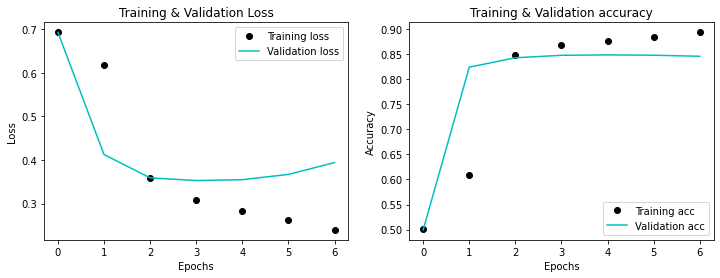

1300/1300 - 3s - loss: 0.4054 - accuracy: 0.8403
test_loss : 0.4053753912448883 test_acc : 0.8403058052062988


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(sp_test,  labels_test, verbose=2)
print_result(results)

배치 사이즈는 512, 얼리스탑핑을 적용하고 모델 학습 결과 약 84%의 정확도를 보여줍니다.

상당히 준수한 결과입니다.

- - -
### 여러 모델 비교하기
- **KoNLPy**

그렇다면 KoNLPy 모듈을 불러와서 본격적으로 SentencePiece와 비교를 해보도록 하죠.

In [ ]:
data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


데이터를 불러오면 문장의 길이를 필터링한 직후의 데이터가 그대로 남아있습니다.

KoNLPy에선 다양한 형태소 분석기 모델을 제공하는데요.

아직 완벽하다고 하는 모델도 없고, 데이터셋에 따라 좋은 분석기 모델이 달라지는 모양이니

Meacb, Kkma, Okt 세 가지를 불러와서 비교해보고 사용하겠습니다.

In [ ]:
sample_sentence = data['document'].sample(15)

sample_sentence

80473               방금 OBS에서 봤는데 숨도 못 쉴 정도로 감동이었다
9642                  노총각 동화. 예쁜 여배우가 순진무구한 남자와..
116127                    사이코스릴러판타지호러액션코미디멜로뮤직비디오
75642                           정말 감동을 주는 영화이네요..
90296                                   스트레스풀기용영화
76207                       할말없음..재밌다는님들은일부로그러는거임
2514            청리 중국사람입니다. 청리를 보조하는애가 한국마크 달고잇엇지
33230     와 올리버스톤 아직 살아있네 영활 이렇게 뽑을수있나 가볍게 감상하세요~
13446                 이런 식으로 전달하려면 그냥 스틸사진이 더 좋겠다
34508                    이건 뭐 할 말 없음. 평점이 말해주는 영화
43676                       1점도 아깝다..이걸 영화라고 만드냐?
38783                         70년생으로 90년노래들 너무좋다~
50336                             장예모 공리 이름이 아깝다.
90916     생각하게 만드는 영화.. 실제가 될수도 아닐수도 둘 다가 공존하는 영화
136401                   서스펜스 스릴러가 아니라 줄리아로버츠 영화다
Name: document, dtype: object

비교 실험의 샘플 문장을 15개 뽑아줍니다.

In [ ]:
from konlpy.tag import Mecab, Kkma, Okt

sample_Mecab = sample_sentence.apply(Mecab().morphs)
sample_Kkma = sample_sentence.apply(Kkma().morphs)
sample_Okt = sample_sentence.apply(Okt().morphs)

In [ ]:
print(sample_Mecab)

80473     [방금, OBS, 에서, 봤, 는데, 숨, 도, 못, 쉴, 정도, 로, 감동, 이,...
9642         [노총각, 동화, ., 예쁜, 여배우, 가, 순진무구, 한, 남자, 와, ., .]
116127          [사이코, 스릴러, 판타지, 호러, 액션, 코미디, 멜, 로, 뮤직, 비디오]
75642                    [정말, 감동, 을, 주, 는, 영화, 이, 네요, ., .]
90296                                     [스트레스, 풀기, 용, 영화]
76207     [할, 말, 없, 음, ., ., 재밌, 다는, 님, 들, 은, 일부, 로, 그러,...
2514      [청리, 중국, 사람, 입니다, ., 청리, 를, 보조, 하, 는, 애, 가, 한국...
33230     [와, 올리버스톤, 아직, 살, 아, 있, 네, 영활, 이렇게, 뽑, 을, 수, 있...
13446     [이런, 식, 으로, 전달, 하, 려면, 그냥, 스틸, 사진, 이, 더, 좋, 겠, 다]
34508         [이건, 뭐, 할, 말, 없, 음, ., 평점, 이, 말, 해, 주, 는, 영화]
43676          [1, 점, 도, 아깝, 다, ., ., 이걸, 영화, 라고, 만드, 냐, ?]
38783             [70, 년, 생, 으로, 90, 년, 노래, 들, 너무, 좋, 다, ~]
50336                            [장예모, 공리, 이름, 이, 아깝, 다, .]
90916     [생각, 하, 게, 만드, 는, 영화, ., ., 실제, 가, 될, 수, 도, 아닐...
136401                 [서스펜스, 스릴러, 가, 아니, 라, 줄리아로버츠, 영화, 다]
Name: document, dtype: object


In [ ]:
print(sample_Kkma)

80473     [방금, OBS, 에서, 보, 았, 는데, 숨, 도, 못, 쉬, ㄹ, 정도, 로, ...
9642      [노총각, 동화, ., 예쁘, ㄴ, 여배우, 가, 순진무구, 하, ㄴ, 남자, 와,...
116127            [사이코, 스릴러, 판타지, 호, 러, 액션, 코미디, 멜로, 뮤직비디오]
75642                      [정말, 감동, 을, 주, 는, 영화, 이, 네요, ..]
90296                                     [스트레스, 풀기, 용, 영화]
76207     [하, ㄹ, 말, 없, 음, .., 재밌, 다는, 님, 들, 은, 일부, 로, 그러...
2514      [청리, 중국, 사람, 이, ㅂ니다, ., 청리, 를, 보조, 하, 는, 애, 가,...
33230     [오, 아, 올리버, 스톤, 아직, 살, 아, 있, 네, 영활, 이렇게, 뽑, 을,...
13446     [이런, 식, 으로, 전달, 하, 려면, 그냥, 스틸, 사진, 이, 더, 좋, 겠, 다]
34508     [이, 건, 뭐, 하, ㄹ, 말, 없, 음, ., 평점, 이, 말하, 어, 주, 는...
43676         [1, 점, 도, 아깝, 다, .., 이것, 을, 영화, 라고, 만들, 냐, ?]
38783               [70, 년생, 으로, 90, 년, 노래, 들, 너무, 좋, 다, ~]
50336                          [장, 예모, 공리, 이름, 이, 아깝, 다, .]
90916     [생각, 하, 게, 만들, 는, 영화, .., 실, 제가, 되, ㄹ, 수, 도, 아...
136401        [서스펜스, 스릴러, 가, 아니, 라, 줄, 리, 아, 로버츠, 영화, 이, 다]
Name: document, dtype: object


In [ ]:
print(sample_Okt)

80473          [방금, OBS, 에서, 봤는데, 숨도, 못, 쉴, 정도, 로, 감동, 이었다]
9642           [노총각, 동화, ., 예쁜, 여배우, 가, 순진무구, 한, 남자, 와, ..]
116127              [사이코, 스릴러, 판타지, 호러, 액션, 코미디, 멜로, 뮤직비디오]
75642                      [정말, 감동, 을, 주는, 영, 화이, 네, 요, ..]
90296                                     [스트레스, 풀기, 용, 영화]
76207           [할말, 없음, .., 재밌다는, 님, 들, 은, 일부, 로, 그러는거, 임]
2514      [청리, 중국사람, 입니다, ., 청리, 를, 보조, 하는, 애가, 한국, 마크, ...
33230     [와, 올리버스톤, 아직, 살아있네, 영활, 이렇게, 뽑을수있나, 가볍게, 감상, ...
13446           [이런, 식, 으로, 전달, 하려면, 그냥, 스틸, 사진, 이, 더, 좋겠다]
34508               [이건, 뭐, 할, 말, 없음, ., 평점, 이, 말, 해주는, 영화]
43676                [1, 점도, 아깝다, .., 이, 걸, 영화, 라고, 만드냐, ?]
38783                       [70년, 생으로, 90년, 노래들, 너무, 좋다, ~]
50336                              [장예모, 공리, 이름, 이, 아깝다, .]
90916     [생각, 하게, 만드는, 영화, .., 실제, 가, 될수도, 아닐수도, 둘, 다가,...
136401                 [서스펜스, 스릴러, 가, 아니라, 줄리아, 로버츠, 영화, 다]
Name: document, dtype: object


종합적인 평가를 내려보면 먼저 Kkma는 받침이 자꾸 분리가 되네요. 의미적으로 더 작게 정규화하려는 모습이 보입니다.

그리고 Mecab과 Okt 둘은 거의 비슷한데요.

분리된 형태로만 봤을 때는 개인적으로 Okt가 더 결과가 좋지 않나 라는 생각이 들지만(특히 `.`과 `..`을 다르게 보는 것에서 차이가 발생)

Mecab과의 큰 차이는 별로 없는 것 같아서 전부 다 모델에 넣어봐야 알 것 같습니다.

### *Okt*

In [ ]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

Okt_data, tokenizer = tokenize(data['document'].apply(Okt().morphs))

Okt_data

array([[  46,  451,    1, ...,    0,    0,    0],
       [ 706,    1,  375, ...,    0,    0,    0],
       [ 342, 2357, 5460, ...,    0,    0,    0],
       ...,
       [ 861,    9,  293, ...,    0,    0,    0],
       [ 367,  250, 2398, ...,    0,    0,    0],
       [ 891,   11,  136, ...,    0,    0,    0]], dtype=int32)

Okt로 토큰화한 데이터를 `Okt_data`라고 정해주겠습니다.

    keras의 Tokenizer를 사용하면 강제로 공백 기반 토큰화가 되는 것이 아닌가? 싶었는데
    형태소 토큰화를 마친 후에 넣으면 이미 공백이 제거되고 없기 때문에 문제가 없겠더라구요.

In [ ]:
min([sum(tensor) for tensor in Okt_data])

0

이번에는 vocab_size에 의해 모든 문장이 0(PAD 또는 UNK)으로 처리된 데이터가 발생했습니다.~~ㅇㄴ~~

결측치와 마찬가지므로 제거해줘야 합니다.

In [ ]:
len(Okt_data)

165452

혹시 데이터가 잘못될 수 있으니 전체 데이터의 수를 확인해줍시다.

In [ ]:
[sum(tensor) for tensor in Okt_data].count(0)

956

지워야 할 데이터는 *956*개입니다.

In [ ]:
len([tensor for tensor in Okt_data if sum(tensor) > 0])

164496

제거를 하면 *165452*개에서 *956*개를 뺀 *164496*개가 돼야합니다.

In [ ]:
data['okt'] = Okt_data.tolist()

data

,id,document,label,okt
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[46, 451, 1, 22, 6717, 694, 0, 0, 0, 0, 0, 0, ..."
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1,"[706, 1, 375, 52, 500, 3, 206, 1, 1542, 32, 10..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[342, 2357, 5460, 9065, 182, 21, 20, 0, 0, 0, ..."
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[7347, 117, 7711, 1, 234, 51, 11, 79, 1, 27, 3..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0,"[864, 8561, 893, 105, 431, 163, 1952, 42, 1993..."
...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[273, 23, 7, 27, 28, 970, 1937, 5230, 21, 3, 1..."
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[2476, 12, 167, 14, 933, 125, 3726, 643, 0, 0,..."
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0,"[861, 9, 293, 842, 6291, 1, 118, 299, 1501, 0,..."
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,"[367, 250, 2398, 41, 493, 3, 1, 51, 9, 130, 26..."


제거를 하면서 중요한 것은 레이블 데이터가 꼬이지 않게 제거하는 것입니다.

그러기 위해서 일단 데이터프레임에 텐서 컬럼을 추가해주고 레이블과 같이 제거되도록 해주겠습니다.

In [ ]:
Okt_train_data = data[:len(train_data)]
Okt_test_data = data[-len(test_data):]

데이터가 합쳐진 채로 제거하면 또 어디부터가 학습용이고 테스트용 데이터인지 헷갈릴테니

train과 test를 분리한 후에 제거를 진행하겠습니다.

In [ ]:
Okt_train_data = Okt_train_data.iloc[[i for i, tensor in enumerate(Okt_data[:len(train_data)]) if sum(tensor) > 0]]
Okt_test_data = Okt_test_data.iloc[[i for i, tensor in enumerate(Okt_data[-len(test_data):]) if sum(tensor) > 0]]

iloc을 이용해 제거될 인덱스인지 아닌지를 판단해 제거해줬습니다.

    apply(lambda x: sum(x) > 0)을 하면 'unhashable type list' 오류가 나며 안됐습니다.
    이유는 list, dict을 넣으면 뭔가 충돌이 일어난다고 하네요

In [ ]:
Okt_data = pd.concat([Okt_train_data, Okt_test_data], axis=0)

Okt_data

,id,document,label,okt
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[46, 451, 1, 22, 6717, 694, 0, 0, 0, 0, 0, 0, ..."
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1,"[706, 1, 375, 52, 500, 3, 206, 1, 1542, 32, 10..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[342, 2357, 5460, 9065, 182, 21, 20, 0, 0, 0, ..."
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[7347, 117, 7711, 1, 234, 51, 11, 79, 1, 27, 3..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0,"[864, 8561, 893, 105, 431, 163, 1952, 42, 1993..."
...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[273, 23, 7, 27, 28, 970, 1937, 5230, 21, 3, 1..."
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[2476, 12, 167, 14, 933, 125, 3726, 643, 0, 0,..."
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0,"[861, 9, 293, 842, 6291, 1, 118, 299, 1501, 0,..."
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,"[367, 250, 2398, 41, 493, 3, 1, 51, 9, 130, 26..."


제거 후 *164496*개로 일치하는 것을 보니 잘 제거된 것 같습니다.

In [ ]:
Okt_train = np.array(list(Okt_train_data['okt']))
Okt_test = np.array(list(Okt_test_data['okt']))

labels_train = np.asarray(Okt_train_data['label']).astype('float32')
labels_test = np.asarray(Okt_test_data['label']).astype('float32')

print(Okt_train.shape)
print(labels_train.shape)
print(Okt_test.shape)
print(labels_test.shape)

(123158, 40)
(123158,)
(41338, 40)
(41338,)


이전에 했던 것처럼 train과 test를 준비해줍니다.

    list(Okt_train_data['okt'])를 해주지 않으면 1차원 모습의 리스트만 들어가면서 모델에 입력이 안됐습니다.

In [ ]:
val_num = 20000

X_train = Okt_train[:-val_num]
y_train = labels_train[:-val_num]

X_val = Okt_train[-val_num:]
y_val = labels_train[-val_num:]

print(X_train.shape)
print(X_val.shape)

(103158, 40)
(20000, 40)


밸리데이션도 마찬가지로 2만 개의 데이터를 사용해주겠습니다.

In [ ]:
word_vector_dim = 40

model = CustomModel(vocab_size, word_vector_dim)

아웃풋을 문장의 길이인 40으로 변경하고 나머지는 이전 모델과 같습니다.

Epoch 1/15
202/202 [==============================] - 8s 18ms/step - loss: 0.5711 - accuracy: 0.6594 - val_loss: 0.3948 - val_accuracy: 0.8284
Epoch 2/15
202/202 [==============================] - 1s 6ms/step - loss: 0.3510 - accuracy: 0.8491 - val_loss: 0.3557 - val_accuracy: 0.8437
Epoch 3/15
202/202 [==============================] - 1s 6ms/step - loss: 0.3216 - accuracy: 0.8620 - val_loss: 0.3735 - val_accuracy: 0.8348
Epoch 4/15
202/202 [==============================] - 1s 6ms/step - loss: 0.3079 - accuracy: 0.8661 - val_loss: 0.3619 - val_accuracy: 0.8432
Epoch 5/15
202/202 [==============================] - 1s 6ms/step - loss: 0.2954 - accuracy: 0.8699 - val_loss: 0.3720 - val_accuracy: 0.8403


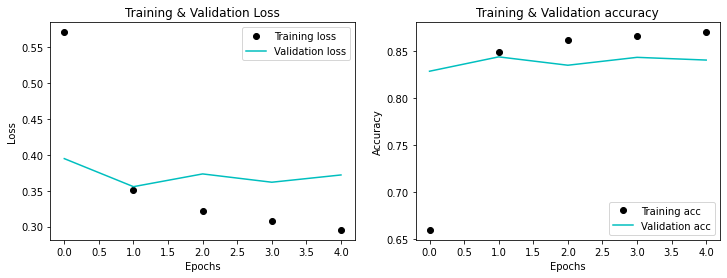

1292/1292 - 3s - loss: 0.3794 - accuracy: 0.8378
test_loss : 0.3794073462486267 test_acc : 0.837848961353302


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(Okt_test,  labels_test, verbose=2)
print_result(results)

학습이 더 빨리 진행되면서 비슷한 정확도가 나왔습니다.

그렇다고 해서 SentencePiece를 활용할 기법이 KoNLPy의 모듈을 사용한 것보다 좋다라는 결론은 아닙니다.

모델 설계를 처음에 진행한 SentencePiece를 기준으로 설계했으니까요.

### *Mecab*

In [ ]:
Mecab_data, tokenizer = tokenize(data['document'].apply(Mecab().morphs))
data['mecab'] = Mecab_data.tolist()

Mecab_train_data = data[:len(train_data)]
Mecab_test_data = data[-len(test_data):]

Mecab_train_data = Mecab_train_data.iloc[[i for i, tensor in enumerate(Mecab_data[:len(train_data)]) if sum(tensor) > 0]]
Mecab_test_data = Mecab_test_data.iloc[[i for i, tensor in enumerate(Mecab_data[-len(test_data):]) if sum(tensor) > 0]]

Mecab_data = pd.concat([Mecab_train_data, Mecab_test_data], axis=0)

Mecab_data

,id,document,label,okt,mecab
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[46, 451, 1, 22, 6717, 694, 0, 0, 0, 0, 0, 0, ...","[37, 80, 882, 1, 1, 41, 222, 26, 42, 759, 0, 0..."
1,3819312,흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나,1,"[706, 1, 375, 52, 500, 3, 206, 1, 1542, 32, 10...","[814, 1, 1, 440, 504, 555, 3, 130, 1, 1, 1503,..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[342, 2357, 5460, 9065, 182, 21, 20, 0, 0, 0, ...","[29, 159, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[7347, 117, 7711, 1, 234, 51, 11, 79, 1, 27, 3...","[6659, 162, 2745, 1, 1, 289, 81, 4, 20, 5, 1, ..."
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.,0,"[864, 8561, 893, 105, 431, 163, 1952, 42, 1993...","[763, 138, 404, 205, 1547, 666, 71, 1766, 652,..."
...,...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[273, 23, 7, 27, 28, 970, 1937, 5230, 21, 3, 1...","[339, 12, 54, 43, 202, 48, 40, 4261, 3815, 204..."
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[2476, 12, 167, 14, 933, 125, 3726, 643, 0, 0,...","[2242, 19, 244, 7, 4, 56, 5, 11, 961, 228, 149..."
49997,9072549,그림도 좋고 완성도도 높았지만.. 보는 내내 불안하게 만든다,0,"[861, 9, 293, 842, 6291, 1, 118, 299, 1501, 0,...","[903, 10, 23, 6, 1376, 10, 245, 52, 47, 1, 1, ..."
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,"[367, 250, 2398, 41, 493, 3, 1, 51, 9, 130, 26...","[414, 464, 4, 38, 320, 3, 1, 1, 81, 10, 20, 6,..."


그럼 Okt와 비슷한 성능으로 형태소가 분리되었던 Mecab도 한 번 써보겠습니다.

빠르게 결측치 제거까지 모두 진행했습니다.

Okt와 성능은 큰 차이가 없어보였는데 처리 속도 측면에선 Mecab이 눈에 띄게 빠르군요.

In [ ]:
Mecab_train = np.array(list(Mecab_train_data['mecab']))
Mecab_test = np.array(list(Mecab_test_data['mecab']))

labels_train = np.asarray(Mecab_train_data['label']).astype('float32')
labels_test = np.asarray(Mecab_test_data['label']).astype('float32')

print(Mecab_train.shape)
print(labels_train.shape)
print(Mecab_test.shape)
print(labels_test.shape)

(123563, 48)
(123563,)
(41465, 48)
(41465,)


In [ ]:
val_num = 20000

X_train = Mecab_train[:-val_num]
y_train = labels_train[:-val_num]

X_val = Mecab_train[-val_num:]
y_val = labels_train[-val_num:]

print(X_train.shape)
print(X_val.shape)

(103563, 48)
(20000, 48)


In [ ]:
word_vector_dim = 48

model = CustomModel(vocab_size, word_vector_dim)

마찬가지로 임베딩 아웃풋을 제외한 나머지는 모두 같습니다.

Epoch 1/15
203/203 [==============================] - 5s 19ms/step - loss: 0.6264 - accuracy: 0.6025 - val_loss: 0.4054 - val_accuracy: 0.8255
Epoch 2/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3653 - accuracy: 0.8454 - val_loss: 0.3580 - val_accuracy: 0.8441
Epoch 3/15
203/203 [==============================] - 2s 10ms/step - loss: 0.3256 - accuracy: 0.8630 - val_loss: 0.3582 - val_accuracy: 0.8453
Epoch 4/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3093 - accuracy: 0.8697 - val_loss: 0.3562 - val_accuracy: 0.8463
Epoch 5/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2962 - accuracy: 0.8754 - val_loss: 0.3552 - val_accuracy: 0.8487
Epoch 6/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2851 - accuracy: 0.8791 - val_loss: 0.3665 - val_accuracy: 0.8426
Epoch 7/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2714 - accuracy: 0.8831 - val_loss: 0.3711 - val_accuracy: 0.8430
Epoc

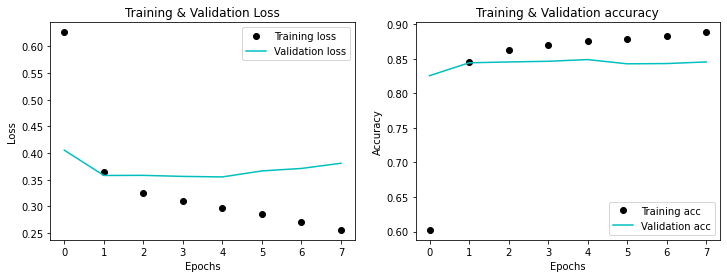

1296/1296 - 3s - loss: 0.3888 - accuracy: 0.8446
test_loss : 0.3887712359428406 test_acc : 0.8446400761604309


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(Mecab_test,  labels_test, verbose=2)
print_result(results)

정확도 또한 Okt보다 높게 나왔습니다.

컴퓨터가 읽기엔 Mecab이 더 의미 있게 형태소를 분리했다고 보는 게 좋겠군요.

- - -
### 여러 모델 비교하기
- **SentencePiece(bpe)**

마지막으로 SentencePiece의 모델 타입을 BPE로 주고 학습을 진행해보겠습니다.

과연 유의미한 성능 변화가 있을까요?

In [ ]:
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --model_type=bpe --vocab_size=10000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vo

-rw-r--r-- 1 root root 409784 Nov 22 00:53 korean_spm.model
-rw-r--r-- 1 root root 150990 Nov 22 00:53 korean_spm.vocab


trainer_spec의 네 번째 특성에 `model_type: BPE`가 추가된 것을 볼 수 있습니다.

In [ ]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[5884, 940, 8683, 8412, 1483, 8408, 8512, 8402, 8400]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


unigram : `▁아버지 가 방 에 들어 가 신 다 .`  
    bpe : `▁아버 지가 방 에 들어 가 신 다 .`
    
unigram이 기본값인 이유가 있었던걸까요?

좀 더 다양한 문장으로 비교해보기 위해 일단 계속 진행해보겠습니다.

In [ ]:
sp_data, word_index, index_word = sp_tokenize(s, data['document'])

sp_data

array([[   7, 1019,    3, ...,    0,    0,    0],
       [1309,    3, 4567, ...,    0,    0,    0],
       [  18, 8421, 9911, ...,    0,    0,    0],
       ...,
       [1598, 8411,  772, ...,    0,    0,    0],
       [ 771, 1433, 8403, ...,    0,    0,    0],
       [4663,  335,  251, ...,    0,    0,    0]], dtype=int32)

In [ ]:
min([sum(tensor) for tensor in sp_data])

5

아까부터 SentencePiece는 vocab_size 10000으로도 결측치가 발생하지 않았습니다.

아무래도 SentencePiece의 구조적 특징인 것 같네요.

In [ ]:
sp_train = sp_data[:len(train_data)]
sp_test = sp_data[-len(test_data):]

labels_train = np.asarray(train_data['label']).astype('float32')
labels_test = np.asarray(test_data['label']).astype('float32')

print(sp_train.shape)
print(labels_train.shape)
print(sp_test.shape)
print(labels_test.shape)

(123860, 50)
(123860,)
(41592, 50)
(41592,)


In [ ]:
for i, sen in enumerate(sp_train[:15]):
    print([index_word[idx] for idx in sen if index_word[idx] != '<unk>'], labels_train[i])

['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리'] 0.0
['▁흠', '..', '포스터', '보고', '▁초딩', '영화', '줄', '..', '오', '버', '연기', '조차', '▁가볍', '지', '▁않', '구나'] 1.0
['▁너무', '재', '밓', '었다', '그래서', '보는', '것을', '추천', '한다'] 0.0
['▁교', '도', '소', '▁이야기', '구먼', '▁..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조정'] 0.0
['▁막', '▁걸', '음', '마', '▁', '▁3', '세', '부터', '▁초등학교', '▁1', '학년', '생', '인', '▁8', '살', '용', '영화', '..', '별', '반', '개도', '▁아까움', '.'] 0.0
['▁원작의', '▁긴장감을', '▁제대로', '▁살려', '내', '지못', '했다', '.'] 0.0
['▁액션이', '▁없는데', '도', '▁재미', '▁있는', '▁몇', '안되는', '▁영화'] 1.0
['▁왜케', '▁평점이', '▁낮은', '건데', '?', '▁꽤', '▁볼만한데', '..', '▁헐리우드', '식', '▁화려', '함', '에만', '▁너무', '▁길', '들여', '져', '▁있나', '?'] 1.0
['▁걍', '인', '피', '니', '트가', '짱', '이다', '.', '진짜', '짱', '이다'] 1.0
['▁볼때마다', '▁눈물', '나서', '▁죽', '겠다', '90', '년대', '의', '▁향', '수', '자', '극', '!', '허', '진호', '는', '▁감성', '절', '제', '멜로', '의', '▁달', '인', '이다', '~'] 1.0
['▁울면서', '▁손', '들고', '▁', '횡', '단', '보', '도', '▁건', '널', '때', '▁뛰', '쳐', '나올', '뻔', '▁이', '범', '수', '▁연기', '▁

이것만 봐서는 아직 잘 모르겠습니다.

unigram을 썻던 모델과 비교해줄 표를 만들어보도록 하죠.

|원본|unigram|bpe|발생한 차이|
|:---|:---|:---|:---:|
|아 더빙.. 진짜 짜증나네요 목소리|아 더빙 .. 진짜 짜증나 네요 목소리|아 더빙 .. 진짜 짜증나 네요 목소리||
|흠..포스터보고 초딩영화줄..오버연기조차 가볍지 않구나|흠 .. 포스터 보고 초딩 영화 줄 .. 오 버 연기 조차 가볍지 않 구나|흠 .. 포스터 보고 초딩 영화 줄 .. 오 버 연기 조차 가볍 지 않 구나|가볍지≠가볍 지|
|너무재밓었다그래서보는것을추천한다|너무 재 밓 었다 그래서 보는 것을 추천 한다|너무 재 밓 었다 그래서 보는 것을 추천 한다||
|교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정|교 도 소 이야기 구먼  .. 솔직히 재미는 없다 .. 평점 조정|교 도 소 이야기 구먼  .. 솔직히 재미는 없다 .. 평점 조정||
|막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화..별반개도 아까움.|막 걸 음 마  3 세 부터 초등학교 1 학년 생 인 8 살 용 영화 .. 별 반 개도 아까움 .|막 걸 음 마  3 세 부터 초등학교 1 학년 생 인 8 살 용 영화 .. 별 반 개도 아까움 .||
|원작의 긴장감을 제대로 살려내지못했다.|원작의 긴장감 을 제대로 살려 내 지 못 했다 .|원작의 긴장감을 제대로 살려 내 지못 했다 .|긴장감 을≠긴장감을/내 지 못 했다≠내 지못 했다|
|액션이 없는데도 재미 있는 몇안되는 영화|액션이 없는데 도 재미 있는 몇안되는 영화|액션이 없는데 도 재미 있는 몇 안되는 영화|몇안되는≠몇 안되는|
|왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?|왜케 평점이 낮은 건데 ? 꽤 볼만한데 .. 헐리우드 식 화려함 에만 너무 길 들 여 져 있나 ?|왜케 평점이 낮은 건데 ? 꽤 볼만한데 .. 헐리우드 식 화려 함 에만 너무 길 들여 져 있나 ?|화려함 에만≠화려 함 에만/길 들 여 져≠길 들여 져|
|걍인피니트가짱이다.진짜짱이다|걍 인 피 니 트 가 짱 이다 . 진짜 짱 이다|걍 인 피 니 트가 짱 이다 . 진짜 짱 이다|인 피 니 트 가≠인 피 니 트가|
|볼때마다 눈물나서 죽겠다90년대의 향수자극!허진호는 감성절제멜로의 달인이다~|볼때마다 눈물나 서 죽 겠다 90 년대 의 향수 자 극 ! 허 진 호 는 감성 절 제 멜로 의 달 인 이다 ~|볼때마다 눈물 나서 죽 겠다 90 년대 의 향 수 자 극 ! 허 진호 는 감성 절 제 멜로 의 달 인 이다 ~|눈물나 서≠눈물 나서/향수≠향 수/허 진 호≠허 진호|
|울면서 손들고 횡단보도 건널때 뛰쳐나올뻔 이범수 연기 드럽게못해|울면서 손 들고  횡 단 보 도 건 널 때 뛰쳐 나올 뻔 이범수 연기 드럽게 못해|울면서 손 들고  횡 단 보 도 건 널 때 뛰 쳐 나올 뻔 이 범 수 연기 드럽게 못해|뛰쳐≠뛰 쳐/이범수≠이 범 수|
|담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다는 것을.|담백하 고 깔끔 해서 좋다 . 신 문 기 사 로만 보다 보면 자꾸 잊 어 버린 다 . 그 들도 사람 이었다 는 것을 .|담백 하고 깔끔 해서 좋다 . 신 문 기 사 로만 보다 보면 자꾸 잊 어 버 린다 . 그 들도 사람이 었다는 것을 .|담백하 고≠담백 하고/잊 어 버린 다≠잊 어 버 린다/사람 이었다 는≠사람이 었다는|
|냥 매번 긴장되고 재밋음| 냥 매번 긴장 되고 재밋음| 냥 매 번 긴장 되고 재밋음|매번≠매 번|
|굿바이 레닌 표절인것은 이해하는데 왜 뒤로 갈수록 재미없어지냐|굿바이 레 닌 표절 인것 은 이해 하는데 왜 뒤로 갈수록 재미없어 지 냐|굿 바이 레 닌 표절 인 것은 이해 하는데 왜 뒤로 갈수록 재미없어 지 냐|굿바이≠굿 바이/인것 은≠인 것은|
|이건 정말 깨알 캐스팅과 질퍽하지않은 산뜻한 내용구성이 잘 버무러진 깨알일드!|이건 정말 깨알 캐스팅 과 질 퍽 하 지않은 산 뜻 한 내용 구성 이 잘 버 무 러 진 깨알 일 드 !|이건 정말 깨알 캐스팅 과 질 퍽 하지않 은 산 뜻 한 내용 구 성이 잘 버무 러진 깨알 일 드 !|하 지않은≠하지않 은/구성 이≠구 성이/버 무 러 진≠버무 러진|

퀄리티에서 차이가 크게 발생하진 않았습니다. 어떤 문장은 unigram이 더 자연스럽고, 또 어떤 문장은 bpe가 자연스럽게 느껴집니다.

하지만 제가 생각하는 정확한 형태소 분리는 unigram이 더 가깝다는 생각이 드네요.

그럼 모델에 넣었을 때는 어떤 차이가 발생할까요.

In [ ]:
val_num = 20000

X_train = sp_train[:-val_num]
y_train = labels_train[:-val_num]

X_val = sp_train[-val_num:]
y_val = labels_train[-val_num:]

print(X_train.shape)
print(X_val.shape)

(103860, 50)
(20000, 50)


In [ ]:
word_vector_dim = 50

model = CustomModel(vocab_size, word_vector_dim)

Epoch 1/15
203/203 [==============================] - 5s 12ms/step - loss: 0.6432 - accuracy: 0.5778 - val_loss: 0.4277 - val_accuracy: 0.8083
Epoch 2/15
203/203 [==============================] - 1s 6ms/step - loss: 0.3741 - accuracy: 0.8389 - val_loss: 0.3563 - val_accuracy: 0.8432
Epoch 3/15
203/203 [==============================] - 1s 7ms/step - loss: 0.3206 - accuracy: 0.8640 - val_loss: 0.3592 - val_accuracy: 0.8385
Epoch 4/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2989 - accuracy: 0.8712 - val_loss: 0.3608 - val_accuracy: 0.8436
Epoch 5/15
203/203 [==============================] - 1s 6ms/step - loss: 0.2806 - accuracy: 0.8767 - val_loss: 0.3612 - val_accuracy: 0.8453


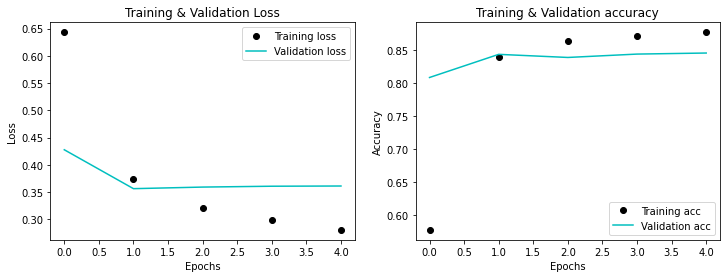

1300/1300 - 3s - loss: 0.3643 - accuracy: 0.8430
test_loss : 0.3643030524253845 test_acc : 0.8429746031761169


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 15

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[es]
                    )

history_graph(history)

results = model.evaluate(sp_test, labels_test, verbose=2)
print_result(results)

결과는 bpe가 살짝 더 좋게 나오네요.

## 마무리하며

|model|loss|accuracy|epochs|비고|
|:---|:---|:---|:---:|:---:|
|SentencePiece(unigram)|0.405375|0.840305|7||
|SentencePiece(bpe)|0.364303|0.842974|5||
|KoNLPy(Okt)|0.379407|0.837848|5||
|KoNLPy(Mecab)|0.388771|0.844640|8|연산 처리가 빠름|
|KoNLPy(Kkma)||||메모리 초과|

loss는 **`SentencePiece(bpe)`**가 *0.364303*으로 가장 낮은 손실을 기록했고,

accuracy는 **`KoNLPy(Mecab)`**이 *0.844640*으로 가장 높은 정확도를 기록했습니다.

### *SentencePiece(unigram)*

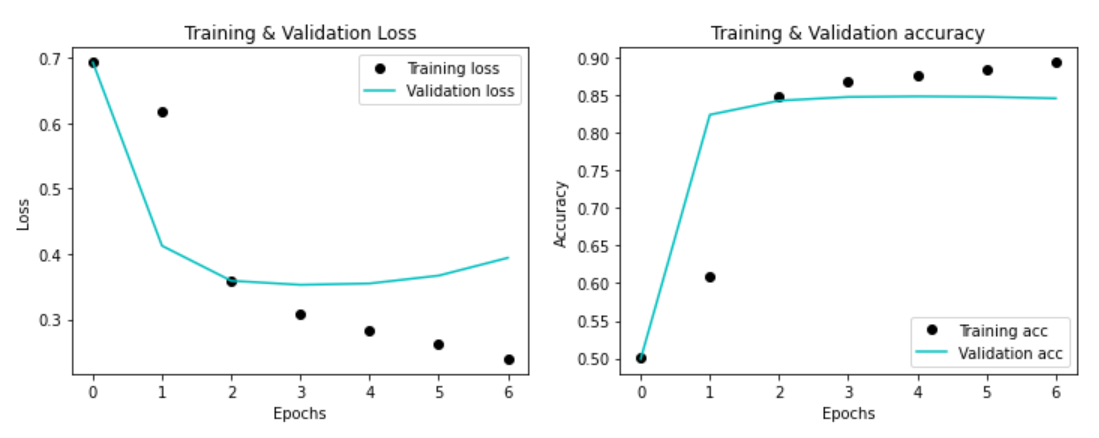

### *SentencePiece(bpe)*

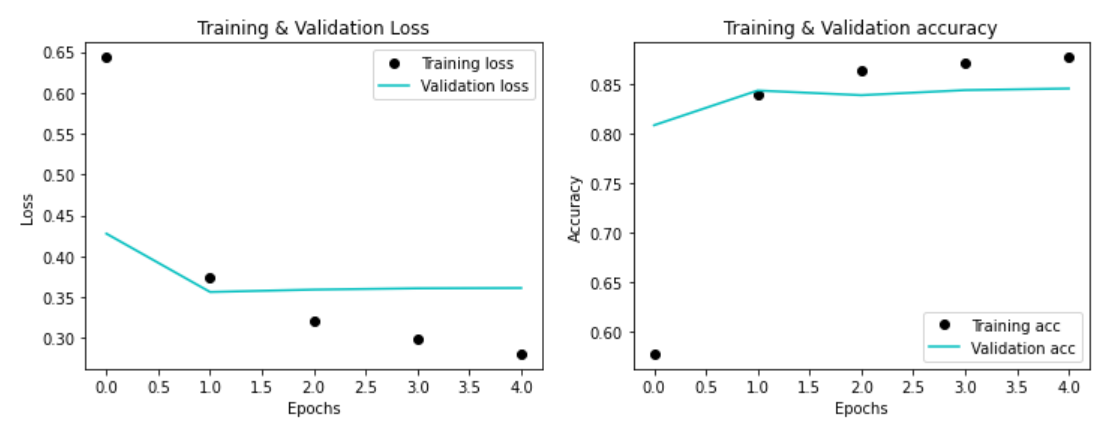

### *KoNLPy(Okt)*

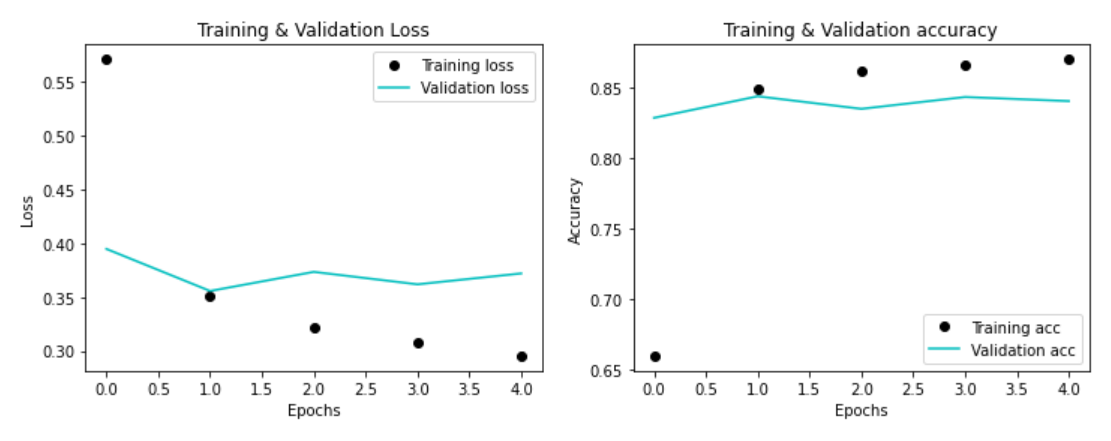

### *KoNLPy(Mecab)*

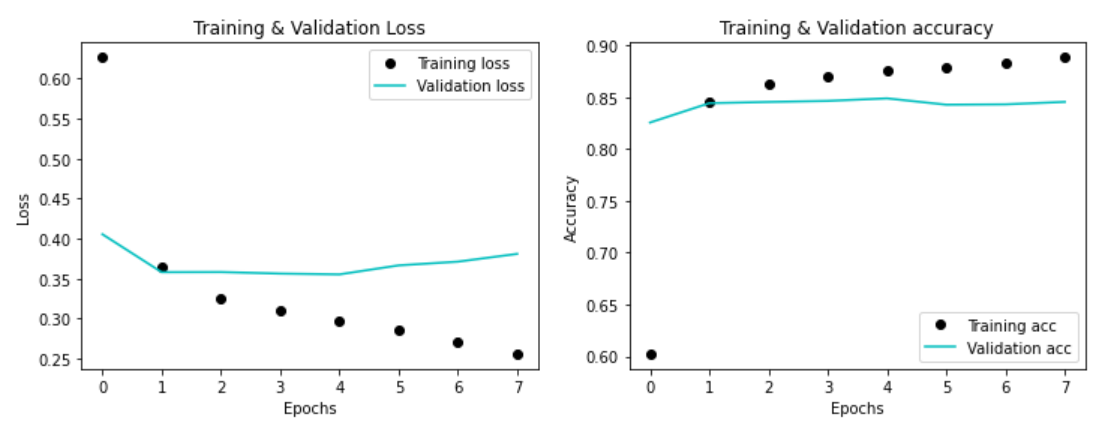

모델이 정확히 고정된 시드도 아닌데다 맨 처음 분석한 SentencePiece(unigram)을 기준으로 설계한 모델이라 정확한 비교는 아니겠지만

SentencePiece가 예상보다 훨씬 좋은 성능을 보여줬습니다. 잘 학습된 KoNLPy 모듈을 이겼다고 보기에는 힘들겠지만,

오히려 적은 학습량을 이 정도의 수준을 보여주는 부분에 대해서는 저는 굉장히 높게 평가하고 있습니다.

동시에 완벽한 형태소 분리기를 만들기란 생각보다 쉽지 않을 것이란 생각도 드네요.

Kkma는 Mecab 이후에 시도는 해보았지만 메모리 초과 문제로 그냥 시도하지 않았습니다.